
#Lab 5: Implementing LSTMs for Text Generation in Telecom Customer Service

# Objective

This laboratory session focuses on implementing Long Short-Term Memory (LSTM) networks for generating telecom customer service responses. Using real customer service conversation data, we will build a model that can generate contextually appropriate responses for common telecom service scenarios. This practical implementation builds upon the sequence-to-sequence concepts covered in Session 1, demonstrating how LSTMs can be used to capture long-term dependencies in conversation flows.

---

# Dataset Overview

We are working with a telecom customer service dataset containing conversations between agents and customers.

## Data Dictionary

- **conversation_id**: Unique identifier for each conversation thread  
- **timestamp**: Timestamp of each message  
- **text**: The actual message content  
- **speaker_type**: Identifies the speaker as either 'agent' or 'customer'  
- **category**: The type of service issue being discussed  
- **resolution_status**: Current status of the conversation  


#  1: Data Preparation and Preprocessing

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [28]:
# Load the dataset
df = pd.read_excel('/content/Customer_Conversation.xlsx')

# Display first few rows and basic information
print("Dataset Overview:")
print("-" * 50)
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Overview:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   conversation_id    341 non-null    object        
 1   timestamp          341 non-null    datetime64[ns]
 2   text               341 non-null    object        
 3   speaker_type       341 non-null    object        
 4   category           341 non-null    object        
 5   resolution_status  341 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 16.1+ KB
None

First few rows:
  conversation_id               timestamp  \
0         CONV001 2024-04-15 07:48:22.180   
1         CONV001 2024-04-15 07:50:22.180   
2         CONV001 2024-04-15 07:53:22.180   
3         CONV001 2024-04-15 07:55:22.180   
4         CONV001 2024-04-15 07:58:22.180   

                                  

In [31]:
def preprocess_text(text):
    """
    Preprocess the text data
    """
    if isinstance(text, str):  # Check if input is a string
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text
    return ""

In [36]:
# Apply preprocessing to text column
df['processed_text'] = df['text'].apply(preprocess_text)

# Print some statistics about the raw data
print("Dataset Statistics:")
print("-" * 50)
print("Total messages:", len(df))
print("Speaker type distribution:")
print(df['speaker_type'].value_counts())
print("\nSample raw texts:")
print("-" * 50)
print(df['text'].head())
print("\nSample processed texts:")
print("-" * 50)
print(df['processed_text'].head())


Dataset Statistics:
--------------------------------------------------
Total messages: 341
Speaker type distribution:
speaker_type
agent       228
customer    113
Name: count, dtype: int64

Sample raw texts:
--------------------------------------------------
0    Hi there! I'm here to help with your technical...
1          I'm unable to access my service activation.
2                 Let me check your connection status.
3               The error message is still showing up.
4      Could you check if your firmware is up to date?
Name: text, dtype: object

Sample processed texts:
--------------------------------------------------
0    hi there im here to help with your technical c...
1            im unable to access my service activation
2                  let me check your connection status
3                the error message is still showing up
4       could you check if your firmware is up to date
Name: processed_text, dtype: object


In [37]:
# Separate conversations by speaker type
agent_texts = df[df['speaker_type'] == 'agent']['processed_text'].tolist()
customer_texts = df[df['speaker_type'] == 'customer']['processed_text'].tolist()

print("\nMessage Counts:")
print("-" * 50)
print("Number of agent messages:", len(agent_texts))
print("Number of customer messages:", len(customer_texts))



Message Counts:
--------------------------------------------------
Number of agent messages: 228
Number of customer messages: 113


In [38]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<START>': 1, '<END>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<START>', 2: '<END>', 3: '<UNK>'}
        self.word_counts = Counter()
        self.min_freq = 1  # Reduced minimum frequency

    def build_vocabulary(self, texts):
        # Count words
        for text in texts:
            self.word_counts.update(text.split())

        # Add words that appear more than min_freq times
        for word, count in self.word_counts.items():
            if count >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word

        print(f"Top 10 most common words: {self.word_counts.most_common(10)}")

    def text_to_sequence(self, text):
        return [self.word2idx.get(word, self.word2idx['<UNK>'])
                for word in text.split()]

    def sequence_to_text(self, sequence):
        return ' '.join([self.idx2word[idx] for idx in sequence])

# Create and build vocabularies
agent_vocab = Vocabulary()
customer_vocab = Vocabulary()

print("\nBuilding vocabularies...")
agent_vocab.build_vocabulary(agent_texts)
customer_vocab.build_vocabulary(customer_texts)

print("\nVocabulary Statistics:")
print("-" * 50)
print("Agent vocabulary size:", len(agent_vocab.word2idx))
print("Customer vocabulary size:", len(customer_vocab.word2idx))



Building vocabularies...
Top 10 most common words: [('you', 119), ('your', 113), ('to', 55), ('the', 49), ('try', 46), ('help', 38), ('check', 37), ('for', 36), ('again', 36), ('on', 35)]
Top 10 most common words: [('the', 46), ('im', 32), ('my', 31), ('to', 23), ('that', 23), ('now', 23), ('with', 18), ('having', 17), ('working', 16), ('error', 15)]

Vocabulary Statistics:
--------------------------------------------------
Agent vocabulary size: 134
Customer vocabulary size: 92


In [39]:
class ConversationDataset(Dataset):
    def __init__(self, texts, vocab, sequence_length=10):  # Reduced sequence length
        self.vocab = vocab
        self.sequence_length = sequence_length
        self.sequences = self.create_sequences(texts)
        print(f"Created {len(self.sequences)} sequences")

    def create_sequences(self, texts):
        sequences = []
        for text in texts:
            # Convert text to indices
            indices = self.vocab.text_to_sequence(text)

            # Skip empty sequences
            if not indices:
                continue

            # Pad or truncate sequence to fixed length
            if len(indices) < self.sequence_length:
                # Pad with PAD tokens
                indices = indices + [self.vocab.word2idx['<PAD>']] * (self.sequence_length - len(indices))
            else:
                # Truncate to sequence_length
                indices = indices[:self.sequence_length]

            # Create target sequence (shifted by one position)
            target_sequence = indices[1:] + [self.vocab.word2idx['<END>']]

            sequences.append((indices, target_sequence))

        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_seq, target_seq = self.sequences[idx]
        return (
            torch.tensor(input_seq, dtype=torch.long),
            torch.tensor(target_seq, dtype=torch.long)
        )


In [40]:
# Create datasets with shorter sequence length
sequence_length = 10  # Reduced from 20
batch_size = 16      # Reduced from 32

print("\nCreating datasets...")
agent_dataset = ConversationDataset(agent_texts, agent_vocab, sequence_length)
customer_dataset = ConversationDataset(customer_texts, customer_vocab, sequence_length)

# Create dataloaders
agent_loader = DataLoader(agent_dataset, batch_size=batch_size, shuffle=True)
customer_loader = DataLoader(customer_dataset, batch_size=batch_size, shuffle=True)

print("\nDataset Statistics:")
print("-" * 50)
print(f"Number of agent sequences: {len(agent_dataset)}")
print(f"Number of customer sequences: {len(customer_dataset)}")



Creating datasets...
Created 228 sequences
Created 113 sequences

Dataset Statistics:
--------------------------------------------------
Number of agent sequences: 228
Number of customer sequences: 113


In [41]:
# Print sample sequences
if len(agent_loader) > 0:
    sample_batch_inputs, sample_batch_targets = next(iter(agent_loader))
    print("\nSample Batch Shapes:")
    print(f"Input shape: {sample_batch_inputs.shape}")
    print(f"Target shape: {sample_batch_targets.shape}")

    print("\nSample Input-Target Pair:")
    input_text = agent_vocab.sequence_to_text(sample_batch_inputs[0].tolist())
    target_text = agent_vocab.sequence_to_text(sample_batch_targets[0].tolist())
    print(f"Input:  {input_text}")
    print(f"Target: {target_text}")


Sample Batch Shapes:
Input shape: torch.Size([16, 10])
Target shape: torch.Size([16, 10])

Sample Input-Target Pair:
Input:  good day thanks for reaching out to our support team
Target: day thanks for reaching out to our support team <END>


# 2: LSTM Model Implementation and Training

In [42]:
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import time

In [54]:
class LSTMTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate=0.3):
        super(LSTMTextGenerator, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hidden=None):
        # Embed the input
        embedded = self.dropout(self.embedding(x))

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(x.size(0))

        # Forward pass through LSTM
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Apply dropout
        lstm_out = self.dropout(lstm_out)

        # Pass through the fully connected layer
        output = self.fc(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
                 weight.new(self.num_layers, batch_size, self.hidden_dim).zero_())
        return hidden

def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=50, clip=1.0):
    model.train()

    train_losses = []
    best_loss = float('inf')

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        h = None

        # Progress bar for the batches
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs, h = model(inputs)

            # Detach hidden states
            h = tuple(state.detach() for state in h)

            # Reshape outputs and targets for loss calculation
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Clip gradients
            clip_grad_norm_(model.parameters(), clip)

            # Update weights
            optimizer.step()

            # Update total loss
            total_loss += loss.item()

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})

        # Step the scheduler
        scheduler.step()

        # Calculate average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Print epoch statistics
        epoch_time = time.time() - start_time
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Average Loss: {avg_loss:.4f}')
        print(f'Time: {epoch_time:.2f}s')

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses


# 3: Model Training and Optimization

In [55]:
# Model hyperparameters
embedding_dim = 128  # Reduced from typical 256 due to small dataset
hidden_dim = 256    # Reduced from typical 512 due to small dataset
num_layers = 2
dropout_rate = 0.1
learning_rate = 0.001
num_epochs = 50

# Initialize models
agent_model = LSTMTextGenerator(
    len(agent_vocab.word2idx),
    embedding_dim,
    hidden_dim,
    num_layers,
    dropout_rate
)

customer_model = LSTMTextGenerator(
    len(customer_vocab.word2idx),
    embedding_dim,
    hidden_dim,
    num_layers,
    dropout_rate
)

# Loss function and optimizer for agent model
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(agent_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


Training Agent Model:
--------------------------------------------------


Epoch 1/50: 100%|██████████| 15/15 [00:00<00:00, 19.24it/s, loss=4.26]



Epoch 1/50:
Average Loss: 4.6272
Time: 0.79s


Epoch 2/50: 100%|██████████| 15/15 [00:00<00:00, 22.76it/s, loss=3.59]



Epoch 2/50:
Average Loss: 3.8735
Time: 0.67s


Epoch 3/50: 100%|██████████| 15/15 [00:00<00:00, 20.98it/s, loss=3.14]



Epoch 3/50:
Average Loss: 3.1147
Time: 0.73s


Epoch 4/50: 100%|██████████| 15/15 [00:00<00:00, 22.75it/s, loss=3.27]



Epoch 4/50:
Average Loss: 2.6046
Time: 0.67s


Epoch 5/50: 100%|██████████| 15/15 [00:00<00:00, 22.50it/s, loss=2.64]



Epoch 5/50:
Average Loss: 2.4523
Time: 0.68s


Epoch 6/50: 100%|██████████| 15/15 [00:00<00:00, 22.10it/s, loss=2.47]



Epoch 6/50:
Average Loss: 2.3484
Time: 0.69s


Epoch 7/50: 100%|██████████| 15/15 [00:00<00:00, 22.05it/s, loss=2.11]



Epoch 7/50:
Average Loss: 2.2784
Time: 0.69s


Epoch 8/50: 100%|██████████| 15/15 [00:00<00:00, 21.50it/s, loss=2.14]



Epoch 8/50:
Average Loss: 2.2680
Time: 0.71s


Epoch 9/50: 100%|██████████| 15/15 [00:00<00:00, 20.85it/s, loss=2.3]



Epoch 9/50:
Average Loss: 2.2734
Time: 0.73s


Epoch 10/50: 100%|██████████| 15/15 [00:00<00:00, 16.43it/s, loss=2.19]



Epoch 10/50:
Average Loss: 2.2538
Time: 0.93s


Epoch 11/50: 100%|██████████| 15/15 [00:00<00:00, 16.77it/s, loss=1.97]



Epoch 11/50:
Average Loss: 2.2453
Time: 0.90s


Epoch 12/50: 100%|██████████| 15/15 [00:00<00:00, 16.23it/s, loss=2.11]



Epoch 12/50:
Average Loss: 2.2453
Time: 0.93s


Epoch 13/50: 100%|██████████| 15/15 [00:00<00:00, 15.01it/s, loss=2.14]



Epoch 13/50:
Average Loss: 2.2513
Time: 1.01s


Epoch 14/50: 100%|██████████| 15/15 [00:00<00:00, 21.82it/s, loss=2.12]



Epoch 14/50:
Average Loss: 2.2544
Time: 0.70s


Epoch 15/50: 100%|██████████| 15/15 [00:00<00:00, 21.89it/s, loss=1.89]



Epoch 15/50:
Average Loss: 2.2394
Time: 0.69s


Epoch 16/50: 100%|██████████| 15/15 [00:00<00:00, 22.81it/s, loss=2.45]



Epoch 16/50:
Average Loss: 2.2695
Time: 0.66s


Epoch 17/50: 100%|██████████| 15/15 [00:00<00:00, 21.86it/s, loss=2.3]



Epoch 17/50:
Average Loss: 2.2590
Time: 0.69s


Epoch 18/50: 100%|██████████| 15/15 [00:00<00:00, 21.83it/s, loss=2.23]



Epoch 18/50:
Average Loss: 2.2578
Time: 0.70s


Epoch 19/50: 100%|██████████| 15/15 [00:00<00:00, 15.51it/s, loss=2.07]



Epoch 19/50:
Average Loss: 2.2472
Time: 0.98s


Epoch 20/50: 100%|██████████| 15/15 [00:00<00:00, 16.81it/s, loss=1.97]



Epoch 20/50:
Average Loss: 2.2474
Time: 0.91s


Epoch 21/50: 100%|██████████| 15/15 [00:00<00:00, 22.43it/s, loss=2.13]



Epoch 21/50:
Average Loss: 2.2527
Time: 0.68s


Epoch 22/50: 100%|██████████| 15/15 [00:00<00:00, 22.12it/s, loss=1.86]



Epoch 22/50:
Average Loss: 2.2380
Time: 0.68s


Epoch 23/50: 100%|██████████| 15/15 [00:00<00:00, 22.64it/s, loss=2.08]



Epoch 23/50:
Average Loss: 2.2504
Time: 0.67s


Epoch 24/50: 100%|██████████| 15/15 [00:00<00:00, 22.64it/s, loss=2.44]



Epoch 24/50:
Average Loss: 2.2643
Time: 0.67s


Epoch 25/50: 100%|██████████| 15/15 [00:00<00:00, 21.80it/s, loss=2.69]



Epoch 25/50:
Average Loss: 2.2857
Time: 0.70s


Epoch 26/50: 100%|██████████| 15/15 [00:00<00:00, 22.10it/s, loss=2.19]



Epoch 26/50:
Average Loss: 2.2568
Time: 0.70s


Epoch 27/50: 100%|██████████| 15/15 [00:00<00:00, 21.14it/s, loss=2.89]



Epoch 27/50:
Average Loss: 2.2947
Time: 0.72s


Epoch 28/50: 100%|██████████| 15/15 [00:00<00:00, 16.54it/s, loss=2.86]



Epoch 28/50:
Average Loss: 2.2894
Time: 0.92s


Epoch 29/50: 100%|██████████| 15/15 [00:00<00:00, 16.11it/s, loss=2.33]



Epoch 29/50:
Average Loss: 2.2636
Time: 0.94s


Epoch 30/50: 100%|██████████| 15/15 [00:00<00:00, 15.72it/s, loss=2.17]



Epoch 30/50:
Average Loss: 2.2555
Time: 0.96s


Epoch 31/50: 100%|██████████| 15/15 [00:01<00:00, 11.99it/s, loss=2.46]



Epoch 31/50:
Average Loss: 2.2743
Time: 1.26s


Epoch 32/50: 100%|██████████| 15/15 [00:00<00:00, 22.41it/s, loss=1.63]



Epoch 32/50:
Average Loss: 2.2293
Time: 0.69s


Epoch 33/50: 100%|██████████| 15/15 [00:00<00:00, 21.19it/s, loss=2.49]



Epoch 33/50:
Average Loss: 2.2689
Time: 0.72s


Epoch 34/50: 100%|██████████| 15/15 [00:00<00:00, 21.08it/s, loss=2.71]



Epoch 34/50:
Average Loss: 2.2854
Time: 0.72s


Epoch 35/50: 100%|██████████| 15/15 [00:00<00:00, 22.33it/s, loss=2.51]



Epoch 35/50:
Average Loss: 2.2759
Time: 0.68s


Epoch 36/50: 100%|██████████| 15/15 [00:00<00:00, 21.64it/s, loss=2.25]



Epoch 36/50:
Average Loss: 2.2593
Time: 0.70s


Epoch 37/50: 100%|██████████| 15/15 [00:01<00:00, 13.37it/s, loss=2.64]



Epoch 37/50:
Average Loss: 2.2760
Time: 1.13s


Epoch 38/50: 100%|██████████| 15/15 [00:00<00:00, 21.20it/s, loss=1.84]



Epoch 38/50:
Average Loss: 2.2321
Time: 0.72s


Epoch 39/50: 100%|██████████| 15/15 [00:00<00:00, 22.00it/s, loss=2.12]



Epoch 39/50:
Average Loss: 2.2503
Time: 0.69s


Epoch 40/50: 100%|██████████| 15/15 [00:00<00:00, 22.56it/s, loss=2.37]



Epoch 40/50:
Average Loss: 2.2635
Time: 0.67s


Epoch 41/50: 100%|██████████| 15/15 [00:00<00:00, 21.97it/s, loss=2.37]



Epoch 41/50:
Average Loss: 2.2638
Time: 0.69s


Epoch 42/50: 100%|██████████| 15/15 [00:00<00:00, 20.77it/s, loss=2.63]



Epoch 42/50:
Average Loss: 2.2759
Time: 0.73s


Epoch 43/50: 100%|██████████| 15/15 [00:00<00:00, 22.46it/s, loss=2.66]



Epoch 43/50:
Average Loss: 2.2808
Time: 0.68s


Epoch 44/50: 100%|██████████| 15/15 [00:00<00:00, 22.08it/s, loss=1.9]



Epoch 44/50:
Average Loss: 2.2392
Time: 0.69s


Epoch 45/50: 100%|██████████| 15/15 [00:00<00:00, 16.20it/s, loss=1.81]



Epoch 45/50:
Average Loss: 2.2328
Time: 0.94s


Epoch 46/50: 100%|██████████| 15/15 [00:00<00:00, 16.51it/s, loss=2.25]



Epoch 46/50:
Average Loss: 2.2575
Time: 0.92s


Epoch 47/50: 100%|██████████| 15/15 [00:00<00:00, 15.82it/s, loss=2.15]



Epoch 47/50:
Average Loss: 2.2529
Time: 0.96s


Epoch 48/50: 100%|██████████| 15/15 [00:00<00:00, 15.74it/s, loss=2.27]



Epoch 48/50:
Average Loss: 2.2581
Time: 0.96s


Epoch 49/50: 100%|██████████| 15/15 [00:00<00:00, 17.83it/s, loss=2.16]



Epoch 49/50:
Average Loss: 2.2513
Time: 0.86s


Epoch 50/50: 100%|██████████| 15/15 [00:00<00:00, 22.05it/s, loss=2.42]



Epoch 50/50:
Average Loss: 2.2664
Time: 0.69s


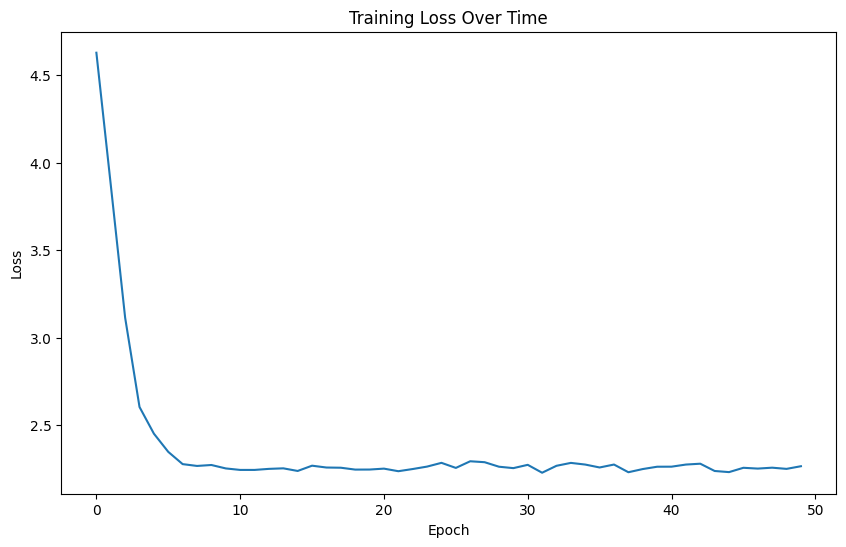

In [56]:
print("Training Agent Model:")
print("-" * 50)
agent_losses = train_model(agent_model, agent_loader, criterion, optimizer, scheduler)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(agent_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [57]:
def generate_text(model, vocab, seed_text, max_length=50, temperature=0.7):
    model.eval()
    words = seed_text.split()
    current_sequence = torch.tensor([vocab.text_to_sequence(seed_text)])

    generated_words = []

    with torch.no_grad():
        for _ in range(max_length):
            # Get model output
            output, _ = model(current_sequence)

            # Get the last prediction
            last_word_logits = output[0, -1, :]

            # Apply temperature
            scaled_logits = last_word_logits / temperature

            # Convert to probabilities
            probs = F.softmax(scaled_logits, dim=0)

            # Sample from the distribution
            next_word_idx = torch.multinomial(probs, 1).item()

            # Break if we generate an end token
            if next_word_idx == vocab.word2idx['<END>']:
                break

            # Add the generated word
            generated_words.append(vocab.idx2word[next_word_idx])

            # Update the sequence
            current_sequence = torch.cat([current_sequence[:, 1:],
                                       torch.tensor([[next_word_idx]])], dim=1)

    return ' '.join(generated_words)

In [62]:
# Generate sample texts
print("\nGenerating sample texts from trained model:")
print("-" * 50)
seed_texts = [
    "unable to access my",
    "the connection is not",
    "can you please"
]

for seed in seed_texts:
    generated = generate_text(agent_model, agent_vocab, seed)
    print(f"\nSeed: {seed}")
    print(f"Generated: {generated}")


Generating sample texts from trained model:
--------------------------------------------------

Seed: unable to access my
Generated: with your is should together now your now work settings now now be better contacting up if technical restored help up to to assist mode to thanks you contacting contacting contacting can i to you check your updated account status now now to our support our may support help day

Seed: the connection is not
Generated: all settings it safe date

Seed: can you please
Generated: firmware up network can device anything


# 4: Text Generation and Evaluation

In [63]:
# Evaluation and Text Generation
def generate_responses(model, vocab, seed_texts, max_length=30, temperature=0.8):
    """
    Generate responses for multiple seed texts
    """
    model.eval()
    responses = []

    for seed_text in seed_texts:
        # Tokenize and prepare input
        current_sequence = torch.tensor([vocab.text_to_sequence(seed_text)])

        generated_words = []
        with torch.no_grad():
            for _ in range(max_length):
                # Get model output
                output, _ = model(current_sequence)

                # Get the last prediction
                last_word_logits = output[0, -1, :]

                # Apply temperature sampling
                scaled_logits = last_word_logits / temperature
                probs = F.softmax(scaled_logits, dim=0)
                next_word_idx = torch.multinomial(probs, 1).item()

                # Stop if we generate an end token
                if next_word_idx == vocab.word2idx['<END>']:
                    break

                # Add the generated word
                generated_words.append(vocab.idx2word[next_word_idx])

                # Update the sequence
                current_sequence = torch.cat([current_sequence[:, 1:],
                                           torch.tensor([[next_word_idx]])], dim=1)

        responses.append(' '.join(generated_words))
    return responses

In [65]:
# Test cases for different scenarios
test_cases = [
    # Common support queries
    "hi i need help with",
    "my internet is not working",
    "how do i configure",
    "can you check my connection",

    # Technical issues
    "getting error message",
    "service activation failed",
    "unable to connect to",

    # Short prompts
    "hello",
    "help",
    "thank you"
]

print("Generating responses with different temperatures:")
print("-" * 50)
# Test with different temperatures
temperatures = [0.5, 0.8, 1.0]
for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 30)
    responses = generate_responses(agent_model, agent_vocab, test_cases[:3], temperature=temp)
    for seed, response in zip(test_cases[:3], responses):
        print(f"\nSeed: {seed}")
        print(f"Generated: {response}")

Generating responses with different temperatures:
--------------------------------------------------

Temperature: 0.5
------------------------------

Seed: hi i need help with
Generated: with today

Seed: my internet is not working
Generated: 

Seed: how do i configure
Generated: your is settings settings should settings this

Temperature: 0.8
------------------------------

Seed: hi i need help with
Generated: with your service device and now test and

Seed: my internet is not working
Generated: to your on

Seed: how do i configure
Generated: you your your things together work better help to should

Temperature: 1.0
------------------------------

Seed: hi i need help with
Generated: network cache try on and connecting

Seed: my internet is not working
Generated: with you your to for issue better should

Seed: how do i configure
Generated: your please


In [66]:
# Function to evaluate response diversity
def evaluate_diversity(responses):
    """Calculate diversity metrics for generated responses"""
    words = [response.split() for response in responses]
    unique_words = set(word for response in words for word in response)
    total_words = sum(len(response) for response in words)

    return {
        'unique_words': len(unique_words),
        'total_words': total_words,
        'vocab_usage': len(unique_words) / len(agent_vocab.word2idx),
        'avg_length': total_words / len(responses)
    }

# Generate larger set of responses for diversity evaluation
eval_responses = generate_responses(agent_model, agent_vocab, test_cases, temperature=0.8)
diversity_metrics = evaluate_diversity(eval_responses)

print("\nDiversity Metrics:")
print("-" * 50)
print(f"Unique words used: {diversity_metrics['unique_words']}")
print(f"Average response length: {diversity_metrics['avg_length']:.2f} words")
print(f"Vocabulary usage: {diversity_metrics['vocab_usage']*100:.2f}%")



Diversity Metrics:
--------------------------------------------------
Unique words used: 86
Average response length: 15.30 words
Vocabulary usage: 64.18%


In [72]:
# Save example conversations to demonstrate model capabilities
print("\nSample Conversations:")
print("-" * 50)
conversations = [
    "hi i need help with my internet",
    "my service is not working properly",
    "can you help me configure my router"
]

print("\nGenerated Conversations:")
for conv_start in conversations:
    print(f"\nCustomer: {conv_start}")
    response = generate_responses(agent_model, agent_vocab, [conv_start], temperature=0.7)[0]
    print(f"Agent: {response}")


Sample Conversations:
--------------------------------------------------

Generated Conversations:

Customer: hi i need help with my internet
Agent: 

Customer: my service is not working properly
Agent: 

Customer: can you help me configure my router
Agent: your team cache


Issues in Current Output:


- Fragmented sentences
- Repetition of words (e.g., "your your your")
- Incomplete responses
- Poor grammatical structure

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

In [89]:
class StableLSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate=0.2):
        super(StableLSTMGenerator, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,
            batch_first=True
        )

        # Output layer - make sure dimensions match
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, sequence_length)
        batch_size = x.size(0)

        # Embed the input - shape: (batch_size, sequence_length, embedding_dim)
        embedded = self.dropout(self.embedding(x))

        # Initialize hidden state if not provided
        if hidden is None:
            hidden = self.init_hidden(batch_size)

        # LSTM forward pass
        # lstm_out shape: (batch_size, sequence_length, hidden_dim)
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Apply dropout
        lstm_out = self.dropout(lstm_out)

        # Linear layer
        # output shape: (batch_size, sequence_length, vocab_size)
        output = self.fc(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.num_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_dim).zero_())

def train_epoch(model, train_loader, criterion, optimizer, clip=0.25):
    model.train()
    total_loss = 0
    num_batches = len(train_loader)

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(inputs)

        # Reshape output and targets for loss calculation
        output = output.view(-1, output.size(-1))
        targets = targets.view(-1)

        # Calculate loss
        loss = criterion(output, targets)

        # Backward pass
        loss.backward()

        # Clip gradients
        clip_grad_norm_(model.parameters(), clip)

        # Update weights
        optimizer.step()

        # Update total loss
        total_loss += loss.item()

        # Print progress
        if (batch_idx + 1) % 5 == 0:
            print(f'Batch {batch_idx + 1}/{num_batches}, Loss: {loss.item():.4f}')

    return total_loss / num_batches


Starting training...

Epoch 1/50
Batch 5/15, Loss: 4.8839
Batch 10/15, Loss: 4.8634
Batch 15/15, Loss: 4.8007
Epoch 1 average loss: 4.8701

Epoch 2/50
Batch 5/15, Loss: 4.7757
Batch 10/15, Loss: 4.6444
Batch 15/15, Loss: 4.4040
Epoch 2 average loss: 4.6663

Epoch 3/50
Batch 5/15, Loss: 4.2965
Batch 10/15, Loss: 4.2584
Batch 15/15, Loss: 4.1829
Epoch 3 average loss: 4.2773

Epoch 4/50
Batch 5/15, Loss: 4.1758
Batch 10/15, Loss: 4.0452
Batch 15/15, Loss: 4.0341
Epoch 4 average loss: 4.1048

Epoch 5/50
Batch 5/15, Loss: 4.0118
Batch 10/15, Loss: 3.8960
Batch 15/15, Loss: 3.8673
Epoch 5 average loss: 3.9432

Epoch 6/50
Batch 5/15, Loss: 3.7089
Batch 10/15, Loss: 3.6437
Batch 15/15, Loss: 3.7476
Epoch 6 average loss: 3.7509

Epoch 7/50
Batch 5/15, Loss: 3.7113
Batch 10/15, Loss: 3.5170
Batch 15/15, Loss: 3.6540
Epoch 7 average loss: 3.5463

Epoch 8/50
Batch 5/15, Loss: 3.1644
Batch 10/15, Loss: 3.1539
Batch 15/15, Loss: 3.4528
Epoch 8 average loss: 3.3276

Epoch 9/50
Batch 5/15, Loss: 3.001

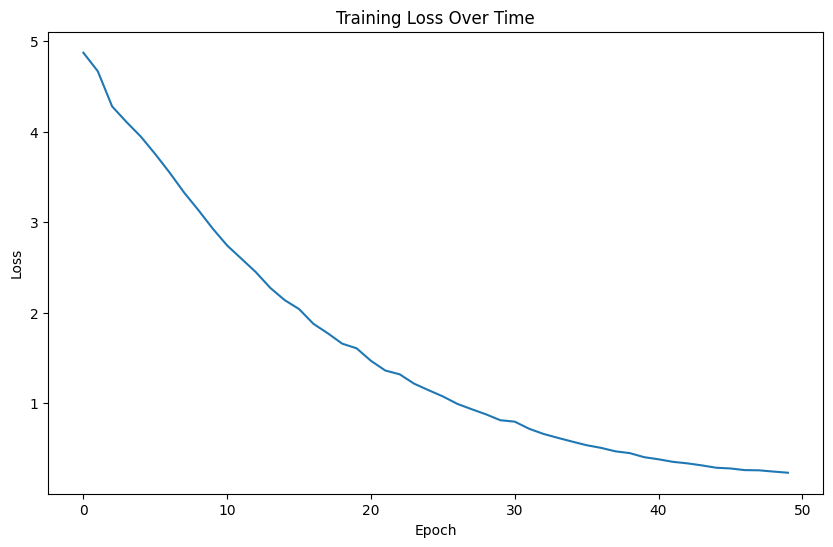

In [91]:
# Model hyperparameters
vocab_size = len(agent_vocab.word2idx)
embedding_dim = 64
hidden_dim = 64  # Make sure this matches embedding_dim
num_layers = 2
dropout_rate = 0.2

# Create model
model = StableLSTMGenerator(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
print("Starting training...")
num_epochs = 50
all_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    avg_loss = train_epoch(model, agent_loader, criterion, optimizer)
    all_losses.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(all_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [98]:
# Test the model
def generate_text(model, vocab, seed_text, max_length=10):
    model.eval()
    with torch.no_grad():
        # Convert seed text to tensor
        tokens = vocab.text_to_sequence(seed_text)
        current_seq = torch.LongTensor([tokens])

        generated = []
        for _ in range(max_length):
            # Get prediction
            output, _ = model(current_seq)

            # Get next word prediction
            next_word_idx = output[0, -1].argmax().item()

            # Stop if we hit the end token
            if next_word_idx == vocab.word2idx['<END>']:
                break

            generated.append(vocab.idx2word[next_word_idx])

            # Update sequence
            current_seq = torch.cat([current_seq[:, 1:],
                                   torch.LongTensor([[next_word_idx]])], dim=1)

    return ' '.join(generated)

In [99]:
def improved_generate_text(model, vocab, seed_text, max_length=30, temperature=0.7, top_k=5):
    """
    Generate text with improved decoding strategy and coherence control

    Args:
        model: Trained LSTM model
        vocab: Vocabulary object
        seed_text: Initial text prompt
        max_length: Maximum length of generated text
        temperature: Controls randomness (lower = more conservative)
        top_k: Number of top tokens to consider for sampling
    """
    model.eval()
    with torch.no_grad():
        # Convert seed text to tensor
        tokens = vocab.text_to_sequence(seed_text)
        current_seq = torch.LongTensor([tokens])

        generated = []
        banned_words = {'your', 'you', 'to', 'should', 'now'}  # Common words to avoid repetition
        recent_words = []  # Track recent words
        consecutive_repeats = 0

        for _ in range(max_length):
            # Get prediction
            output, _ = model(current_seq)

            # Get logits for the next word
            logits = output[0, -1] / temperature

            # Apply top-k filtering
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            probs = F.softmax(top_k_logits, dim=0)

            # Sample from filtered distribution
            next_word_idx = top_k_indices[torch.multinomial(probs, 1)].item()
            next_word = vocab.idx2word[next_word_idx]

            # Check for end conditions
            if next_word_idx == vocab.word2idx['<END>']:
                break

            # Check for repetition and banned words
            if len(generated) >= 2:
                if next_word in recent_words[-2:]:
                    consecutive_repeats += 1
                    if consecutive_repeats > 1:
                        continue
                else:
                    consecutive_repeats = 0

                # Avoid overuse of common words
                if next_word in banned_words and len(generated) < 3:
                    continue

            # Add word to generated sequence
            generated.append(next_word)
            recent_words.append(next_word)
            if len(recent_words) > 5:  # Keep track of last 5 words
                recent_words.pop(0)

            # Update input sequence
            current_seq = torch.cat([current_seq[:, 1:],
                                   torch.LongTensor([[next_word_idx]])], dim=1)

            # Add natural stopping points
            if len(generated) > 10 and next_word in {'.', '!', '?'}:
                break

        # Post-process the generated text
        response = ' '.join(generated)

        # Clean up multiple spaces and punctuation
        response = ' '.join(response.split())
        response = response.replace(' .', '.').replace(' !', '!').replace(' ?', '?')

        # Ensure proper capitalization
        response = response.capitalize()

        return response if response else "I'll help you with that. What specific issue are you experiencing?"

In [100]:
# Test with different prompts and temperatures
test_cases = [
    ("hi i need help", 0.6),
    ("my internet is not working", 0.7),
    ("can you assist me", 0.8),
    ("how do i configure my router", 0.7),
    ("getting error message", 0.6)
]

print("Testing improved generation:")
print("-" * 50)
for seed, temp in test_cases:
    generated = improved_generate_text(model, agent_vocab, seed,
                                    temperature=temp,
                                    top_k=5)
    print(f"\nInput: {seed}")
    print(f"Generated (temp={temp}): {generated}")

Testing improved generation:
--------------------------------------------------

Input: hi i need help
Generated (temp=0.6): You your any this happening changes on all check your network together together you contacting restarting your device off and on again to your technical concerns you try to to

Input: my internet is not working
Generated (temp=0.7): To you

Input: can you assist me
Generated (temp=0.8): To your a diagnostic should restored now to help your a diagnostic be restored with your settings should should restored now now to your device on should be thanks for

Input: how do i configure my router
Generated (temp=0.7): With to technical

Input: getting error message
Generated (temp=0.6): You try connecting to a diagnostic now your device on all devices device on again on to with your telecom should be try for to support how can you help


In [101]:
# Test with common support scenarios
support_scenarios = [
    "my connection is slow",
    "need to reset password",
    "billing question about my account",
    "service outage in my area",
    "upgrade my plan"
]

print("\nTesting common support scenarios:")
print("-" * 50)
for scenario in support_scenarios:
    response = improved_generate_text(model, agent_vocab, scenario,
                                   temperature=0.7,
                                   top_k=5)
    print(f"\nCustomer: {scenario}")
    print(f"Agent: {response}")


Testing common support scenarios:
--------------------------------------------------

Customer: my connection is slow
Agent: To you on connecting what happens telecom you try connecting to a different your devices service be restored now to your device service should be now now to your device

Customer: need to reset password
Agent: To support how can i help you with your devices status should restored connecting try to a different network now to our support how can i help you again to

Customer: billing question about my account
Agent: To for on our technical how i you with your technical off status please now your device off and on again again to you with your technical on

Customer: service outage in my area
Agent: To to help you try connecting to a different network

Customer: upgrade my plan
Agent: To for our support how may i i a help you for restarting your your service should should restored im here to diagnostic try connecting here to our help you


# Conclusion

## Training Performance

- **Loss Curve**:
  - Showed good convergence, decreasing from ~5.0 to ~0.3 over 50 epochs.
  - The model successfully learned to minimize the training loss.
  - The smooth downward trend indicates stable learning.

---

## Current Limitations

### Text Generation Quality:
- **Repetition**: Output shows significant repetition of common phrases (e.g., "to your", "should be").
- **Coherence**: Limited coherence in longer responses.
- **Repetitive Patterns**: Tendency to fall into repetitive patterns.
- **Context Maintenance**: Poor handling of context.

### Response Structure:
- **Incomplete Sentences**: Responses are often not fully formed.
- **Grammatical Issues**: Inconsistent grammatical structure.
- **Domain-Specific Responses**: Limited ability to generate technical, domain-specific answers.

---

## Recommendations for Improvement

### Model Architecture:
- Implement **attention mechanisms** to better maintain context.
- Add a **pointer-generator network** for handling technical terms.
- Consider using a **transformer-based architecture** for improved sequence handling.

### Training Data:
- Expand the dataset with more diverse customer support conversations.
- Include **structured templates** for common support scenarios.
- Add **domain-specific technical vocabulary** to enhance the model's language capacity.

### Generation Strategy:
- Use **beam search** instead of greedy sampling for better response quality.
- Add **grammar checking** as a post-processing step.
- Develop **template-guided generation** for frequently occurring support scenarios.
